<a href="https://colab.research.google.com/github/a-difazio/image-processing/blob/main/localizzazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lettura del File Excel 


   ID    imgName      Fovea_X      Fovea_Y
0   1  A0001.jpg  1182.264278  1022.018842
1   2  A0002.jpg   967.754046  1016.946655
2   3  A0003.jpg  1220.206714   989.944033
3   4  A0004.jpg  1141.140888  1000.594955
4   5  A0005.jpg  1127.371832  1071.109440


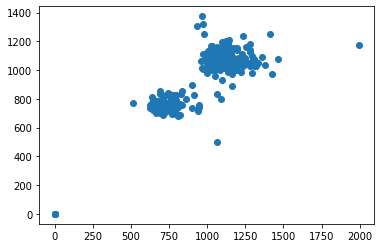

In [11]:
!pip install openpyxl==3.0.0
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_path = 'drive/MyDrive/Training400'
fovea_file = os.path.join(base_path, 'Fovea_location.xlsx')

fovea_data = pd.read_excel(fovea_file)

print(fovea_data.head())

plt.scatter(fovea_data['Fovea_X'], fovea_data['Fovea_Y'])

# abbiamo 5 immagini con fovea non visibile
fovea_data = fovea_data.replace(0, np.nan).dropna().reset_index()

# Funzioni per Caricamento e Preprocessing delle Immagini

In [18]:
from skimage.io import imread, imshow
from skimage.transform import resize

# Dell'immagine ridimensionata
HEIGHT = 256
WIDTH = 256
CHANNELS = 3

def read_images(data):
  images = []
  labels = []

  for i in data.index:
    image_path = os.path.join(base_path, 'images', data.loc[i, 'imgName'])
    image = imread(image_path)
    label = data.loc[i, ['Fovea_X', 'Fovea_Y']].astype('float64').values

    # salviamo altezza e larghezza originali
    h = image.shape[0]
    w = image.shape[1]
    image_resized = resize(image, (HEIGHT, WIDTH), anti_aliasing=False, order=0)

    # converto le coordinate della fovea
    label[0] = (label[0] * HEIGHT) / h
    label[1] = (label[1] * WIDTH) / w

    images.append(image_resized)
    labels.append(label)
  
  return np.stack(images), np.stack(labels)

# Split del Dataset

In [19]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(fovea_data, train_size=0.9, random_state=0)

# Lettura del Train set

In [35]:
train_images, train_labels = read_images(train_data)

In [34]:
index = 100

# Con resize le immagine sono convertite in float64 con range 0-1
print('Images Details')
print(f'Image range {train_images[index].min()}-{train_images[index].max()}')
print(f'Image shape {train_images[index].shape}')
print(f'Image type {train_images[index].dtype}\n')
print('Label Details')
print(f'Label range {train_labels.min()}-{train_labels.max()}')
print(f'Label shape {train_labels[index].shape}')
print(f'Label type {train_labels[index].dtype}\n')

Images Details
Image range 0.0-1.0
Image shape (256, 256, 3)
Image type float64

Label Details
Label range 60.6511087105961-182.163970120061
Label shape (2,)
Label type float64



# Visualizzazione Annotazioni

In [21]:
def visualize_point(img, point):
  x = point[0]
  y = point[1]

  plt.figure(figsize=(6, 6))
  plt.imshow(img)
  #plt.plot(x, y, 'w+', markersize=20)
  plt.plot(x, y, color='#009A99', marker='+', markersize=40, mew=2)
  plt.axis('off')
  plt.show()

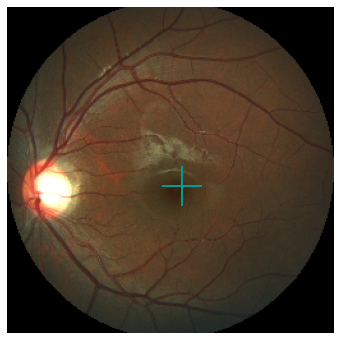

In [22]:
index = 100

visualize_point(train_images[index], train_labels[index])

# Transfer Learning ResNet50

In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers, Model
import tensorflow as tf

CHANNELS = 3

tf.keras.backend.clear_session()

base_model = ResNet50(include_top=False, input_shape=(HEIGHT, WIDTH, CHANNELS))
base_model.trainable = False

flat_1 = layers.Flatten()(base_model.layers[-1].output)
outputs = layers.Dense(2, activation='linear')(flat_1)

model = Model(inputs=base_model.inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

# Visualizzazione del Modello

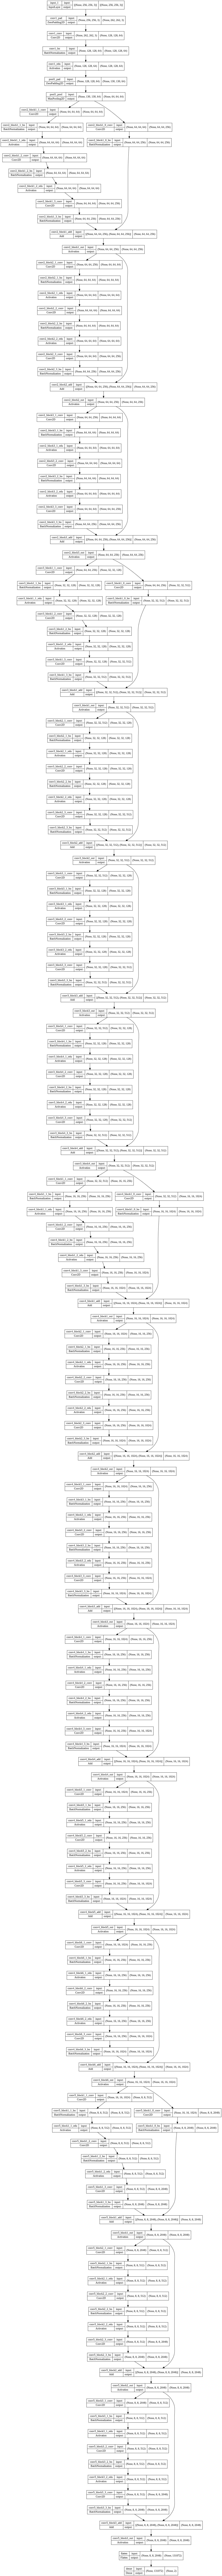

In [24]:
from keras.utils.vis_utils import plot_model

model_plot_path = os.path.join(base_path, 'models', 'resnet', 'model_plot.png')
plot_model(model, to_file=model_plot_path, show_shapes=True, show_layer_names=True)

# Training del Modello

In [25]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

resnet = model.fit(train_images, train_labels, epochs=200, batch_size=30, validation_split=0.2, callbacks=[early_stop])   

Epoch 1/200
10/10 [==============================] - 23s 1s/step - loss: 5421.9268 - root_mean_squared_error: 73.6337 - val_loss: 1101.5548 - val_root_mean_squared_error: 33.1897
Epoch 2/200
10/10 [==============================] - 4s 370ms/step - loss: 1686.6532 - root_mean_squared_error: 41.0689 - val_loss: 621.8887 - val_root_mean_squared_error: 24.9377
Epoch 3/200
10/10 [==============================] - 3s 345ms/step - loss: 286.5078 - root_mean_squared_error: 16.9265 - val_loss: 500.9060 - val_root_mean_squared_error: 22.3809
Epoch 4/200
10/10 [==============================] - 3s 361ms/step - loss: 303.4678 - root_mean_squared_error: 17.4203 - val_loss: 160.3046 - val_root_mean_squared_error: 12.6611
Epoch 5/200
10/10 [==============================] - 3s 346ms/step - loss: 164.5621 - root_mean_squared_error: 12.8282 - val_loss: 157.3722 - val_root_mean_squared_error: 12.5448
Epoch 6/200
10/10 [==============================] - 3s 336ms/step - loss: 110.0617 - root_mean_squared_

# Curve di Apprendimento

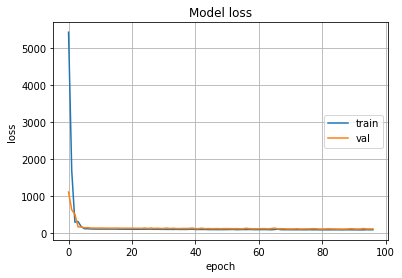

In [26]:
import matplotlib.pyplot as plt

plt.plot(resnet.history['loss'])
plt.plot(resnet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center right')
plt.grid(True)
plt.show()

# Salvataggio del Modello

In [27]:
model_path = os.path.join(base_path, 'models', 'resnet', 'resnet.h5')
model.save(model_path)

# Caricamento del Modello

In [28]:
from tensorflow.keras.models import load_model

model_path = os.path.join(base_path, 'models', 'resnet', 'resnet.h5')

model = load_model(model_path)

# Lettura Test Set

In [29]:
test_images, test_labels = read_images(test_data)

# Valutazione del Modello

In [30]:
results = model.evaluate(test_images, test_labels)

2/2 [==============================] - 4s 853ms/step - loss: 229.2133 - root_mean_squared_error: 15.1398


# Alcuni Esempi di Predizioni

Prediction: [143.03168 130.39093]
Label: [143.34754812 129.70891729]


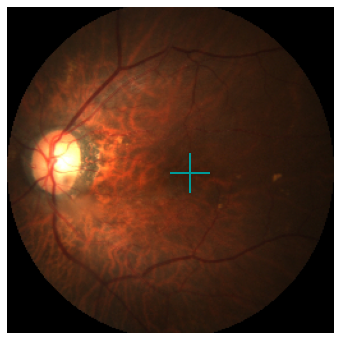

In [33]:
def visualize_prediction(img, pred, truth):
  plt.figure(figsize=(6, 6))
  plt.imshow(img)
  plt.plot(pred[0], pred[1], 'w+', markersize=40, mew=2)
  plt.plot(truth[0], truth[1], color='#009A99', marker='+', markersize=40, mew=2)
  plt.axis('off')
  plt.show()

prediction = model.predict(test_images)
index = 7
print(f'Prediction: {prediction[index]}')
print(f'Label: {test_labels[index]}')
visualize_prediction(test_images[index], prediction[index], test_labels[index])    